In [31]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/30-days-of-ml/sample_submission.csv
/kaggle/input/30-days-of-ml/train.csv
/kaggle/input/30-days-of-ml/test.csv


In [32]:
import sklearn
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import catboost as ctb
import lightgbm as lgb
import random
import os

from sklearn.linear_model import LinearRegression

In [33]:
train = pd.read_csv("/kaggle/input/30-days-of-ml/train.csv", index_col="id")
test  = pd.read_csv("/kaggle/input/30-days-of-ml/test.csv", index_col="id")

target = train["target"]
train = train.drop("target", axis=1)

In [34]:
def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

seed_everything(299792458)

In [64]:
N_ESTIMATORS = 20000
lr = 0.08
SEED = 299792458
SPLITS = 10
VERBOSE = N_ESTIMATORS * 2
EARLY_STOPPING_ROUNDS = 100

In [65]:
xgb_params = {
    "n_estimators":N_ESTIMATORS,
    "learning_rate":lr,
    "seed":SEED,
    "tree_method":'gpu_hist',
    "gpu_id":0,
    "max_depth":2,
    "subsample":0.98,
    "colsample_bytree":0.1,
    "n_jobs":4,
    "booster": 'gbtree', 
    "reg_lambda":66,
    "reg_alpha":15,
    "objective":"reg:squarederror",
    "min_child_weight":256,
    "importance_type":"total_gain",    
}

lgb_params = {
    'objective': 'regression',
    'metric': 'rmse',
    'n_estimators': N_ESTIMATORS,
    'random_state': SEED,
    'learning_rate': lr,
    'subsample': 0.8,
    'subsample_freq': 1,
    'colsample_bytree': 0.6,
    'reg_alpha': 6.4,
    'reg_lambda': 1.8,
    'min_child_weight': 256,
    'min_child_samples': 20,
    'importance_type': 'gain',
    'device': 'gpu',
    'gpu_platform_id': 0,
    'gpu_device_id': 0
}

ctb_params = {
    #'bootstrap_type': 'Poisson',
    'loss_function': 'RMSE',
    'eval_metric': 'RMSE',
    'random_seed': SEED,
    'task_type': 'GPU',
    'max_depth': 5,
    'learning_rate': lr,
    'n_estimators': N_ESTIMATORS,
    'max_bin': 140,
    'min_data_in_leaf': 64,
    'l2_leaf_reg': 0.01,
    'subsample': 0.8
}

In [ ]:
Count_cols   = train.select_dtypes(exclude=['object']).columns
Cat_cols = [ col for col in train.columns if col not in Count_cols ]
print("Number of columns:", len(train.columns))
print("Number of catrgorical columns:", len(Cat_cols))
print("Number of continuous columns:",  len(Count_cols))

ordinalencoder = OrdinalEncoder()

OH_cat_train = pd.DataFrame(ordinalencoder.fit_transform(train[Cat_cols]))
OH_cat_test = pd.DataFrame(ordinalencoder.transform(test[Cat_cols]))

OH_cat_train.index = train.index
OH_cat_test.index = test.index

OH_num_train = train[Count_cols]
OH_num_test = test[Count_cols]

OH_train_X   = pd.concat([OH_cat_train, OH_num_train], axis=1)
OH_test_X   = pd.concat([OH_cat_test, OH_num_test], axis=1)

In [67]:
xgb_oof = np.zeros(train.shape[0])
lgb_oof = np.zeros(train.shape[0])
ctb_oof = np.zeros(train.shape[0])

xgb_pred = np.zeros(test.shape[0])
lgb_pred = np.zeros(test.shape[0])
ctb_pred = np.zeros(test.shape[0])

xgb_importances = pd.DataFrame()
lgb_importances = pd.DataFrame()
ctb_importances = pd.DataFrame()

kfd = KFold(n_splits=SPLITS, shuffle=True, random_state=SEED)

for fold, (train_idx, valid_idx) in enumerate(kfd.split(X=OH_train_X, y=target)):
    print(f"-------------------------- FOLD {fold} --------------------------")
    X_train, X_valid = OH_train_X.iloc[train_idx], OH_train_X.iloc[valid_idx]
    y_train, y_valid = target.iloc[train_idx], target.iloc[valid_idx]
    
    #xgb_model = xgb.XGBRegressor(**xgb_params)
    xgb_model = xgb.XGBRegressor(
            n_estimators=10000,
            learning_rate=lr,
            tree_method='gpu_hist',
            gpu_id=0,
            max_depth=2,
            subsample=0.98,
            colsample_bytree=0.10,
            n_jobs=4,
            booster= 'gbtree', 
            reg_lambda= 66.1,
            reg_alpha= 15.9,
        )
    xgb_model.fit(X_train,
                  y_train,
                  eval_set=[(X_valid, y_valid)],
                  eval_metric="rmse",
                  early_stopping_rounds=EARLY_STOPPING_ROUNDS,
                  verbose=VERBOSE)
    
    valid_preds = xgb_model.predict(X_valid)
    xgb_oof[valid_idx]  = valid_preds
    xgb_pred +=  xgb_model.predict(OH_test_X) / SPLITS
    
    tmp = pd.DataFrame()
    tmp["feature"] = X_train.columns
    tmp["importance"] = xgb_model.feature_importances_
    tmp["seed"] = SEED
    tmp["fold"] = fold
    xgb_importances = xgb_importances.append(tmp)
    
    
    print(f"FOLD: {fold} ---- Valid accuracy XGB: {mean_squared_error(valid_preds, y_valid, squared=False)}")
    
    #------------------------------------------------------------------------------------------------------
    
    lgb_model = lgb.LGBMRegressor(**lgb_params)
    lgb_model.fit(X_train,
                  y_train,
                  eval_set=[(X_valid, y_valid)],
                  eval_metric="rmse",
                  early_stopping_rounds=EARLY_STOPPING_ROUNDS,
                  verbose=VERBOSE)
    
    valid_preds = lgb_model.predict(X_valid)
    lgb_oof[valid_idx]  = valid_preds
    lgb_pred += lgb_model.predict(OH_test_X) / SPLITS
    
    tmp = pd.DataFrame()
    tmp["feature"] = X_train.columns
    tmp["importance"] = lgb_model.feature_importances_
    tmp["seed"] = SEED
    tmp["fold"] = fold
    lgb_importances = lgb_importances.append(tmp)
    
    print(f"FOLD: {fold} ---- Valid accuracy LGB: {mean_squared_error(valid_preds, y_valid, squared=False)}")
    
    #------------------------------------------------------------------------------------------------------
    
    ctb_model = ctb.CatBoostRegressor(**ctb_params)
    ctb_model.fit(X_train,
                  y_train,
                  eval_set=[(X_valid, y_valid)],
                  use_best_model=True,
                  early_stopping_rounds=EARLY_STOPPING_ROUNDS,
                  verbose=VERBOSE)
    
    valid_preds = ctb_model.predict(X_valid)
    ctb_oof[valid_idx]  = valid_preds
    ctb_pred += ctb_model.predict(OH_test_X) / SPLITS
    
    tmp = pd.DataFrame()
    tmp["feature"] = X_train.columns
    tmp["importance"] = ctb_model.feature_importances_
    tmp["seed"] = SEED
    tmp["fold"] = fold
    ctb_importances = ctb_importances.append(tmp)
    
    print(f"FOLD: {fold} ---- Valid accuracy CTB: {mean_squared_error(valid_preds, y_valid, squared=False)}")
    
print(f"oof lgb_rmse = {mean_squared_error(target, lgb_oof, squared=False)}")
print(f"oof xgb_rmse = {mean_squared_error(target, xgb_oof, squared=False)}")
print(f"oof ctb_rmse = {mean_squared_error(target, ctb_oof, squared=False)}")

-------------------------- FOLD 0 --------------------------
[0]	validation_0-rmse:7.16656
[7677]	validation_0-rmse:0.71676
FOLD: 0 ---- Valid accuracy XGB: 0.7167473044880988
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[605]	valid_0's rmse: 0.718991
FOLD: 0 ---- Valid accuracy LGB: 0.7189908680079102
0:	learn: 0.7457786	test: 0.7458034	best: 0.7458034 (0)	total: 7.91ms	remaining: 2m 38s
bestTest = 0.7317876629
bestIteration = 330
Shrink model to first 331 iterations.
FOLD: 0 ---- Valid accuracy CTB: 0.7317877025970567
-------------------------- FOLD 1 --------------------------
[0]	validation_0-rmse:7.16239
[6410]	validation_0-rmse:0.71567
FOLD: 1 ---- Valid accuracy XGB: 0.7156602843470311
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[778]	valid_0's rmse: 0.717797
FOLD: 1 ---- Valid accuracy LGB: 0.7177973881738484
0:	learn: 0.7459000	test: 0.7451472	best: 0.7451472 (0)	total: 7.6

Text(0.5, 1.0, 'LightGBM feature importances')

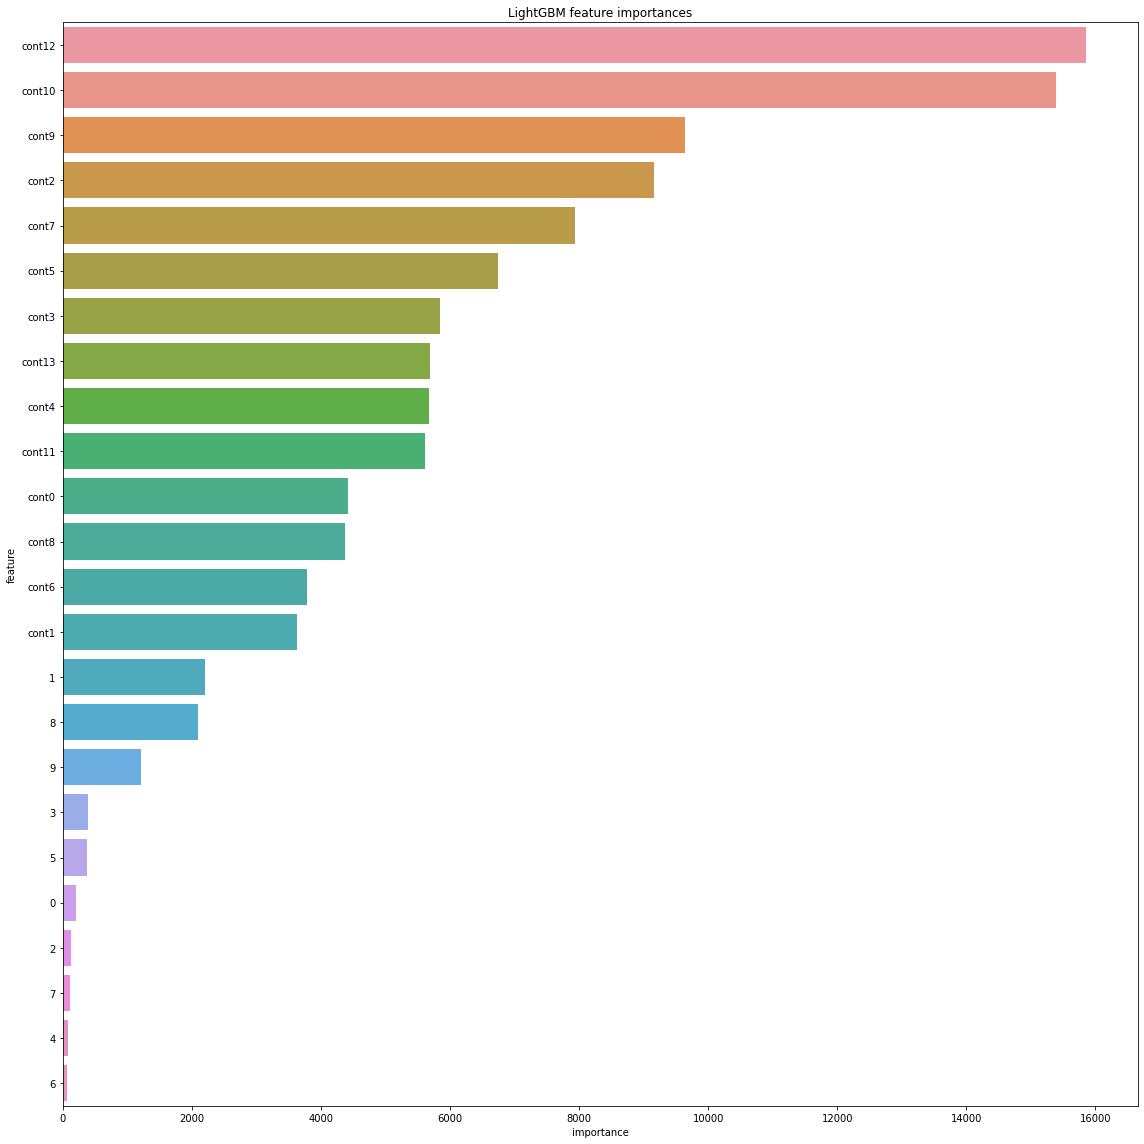

In [68]:
order = list(lgb_importances.groupby('feature').mean().sort_values('importance', ascending=False).index)

fig = plt.figure(figsize=(16, 16), tight_layout=True)
sns.barplot(x="importance", y="feature", data=lgb_importances.groupby('feature').mean().reset_index(), order=order)
plt.title("LightGBM feature importances")

In [104]:
coef = [0.5, 0.5, 0.0]

ensemble1_oof = coef[0] * lgb_oof + coef[1] * xgb_oof + coef[2] * ctb_oof
ensemble1_pred = coef[0] * lgb_pred + coef[1] * xgb_pred + coef[2] * ctb_pred

In [105]:
train_npy  = np.concatenate([ xgb_oof.reshape(-1,1), lgb_oof.reshape(-1,1), ctb_oof.reshape(-1,1)], axis=1)
target_npy = target.to_numpy()

test_npy = np.concatenate([ xgb_pred.reshape(-1,1), lgb_pred.reshape(-1,1), ctb_pred.reshape(-1,1)], axis=1)

In [106]:
stack_oof = np.zeros(train.shape[0])
stack_pred = np.zeros(test.shape[0])

kfd = KFold(n_splits=10, shuffle=True, random_state=SEED)

for fold, (train_idx, valid_idx) in enumerate(kfd.split(X=train_npy, y=target_npy)):
    #print(f"-------------------------- FOLD {fold} --------------------------")
    X_train, X_valid = train_npy[train_idx], train_npy[valid_idx]
    y_train, y_valid = target_npy[train_idx], target_npy[valid_idx]
    
    model = LinearRegression()
    model.fit(X_train,y_train)
    
    valid_preds = model.predict(X_valid)
    stack_oof[valid_idx]  = valid_preds
    stack_pred +=  model.predict(test_npy) / 10
    
    print(f"FOLD: {fold} ---- Valid accuracy XGB: {mean_squared_error(valid_preds, y_valid, squared=False)}")
    
print(mean_squared_error(stack_oof, target_npy, squared=False))

FOLD: 0 ---- Valid accuracy XGB: 0.7165608357250779
FOLD: 1 ---- Valid accuracy XGB: 0.7153248770544938
FOLD: 2 ---- Valid accuracy XGB: 0.7199180777477989
FOLD: 3 ---- Valid accuracy XGB: 0.7178597099031803
FOLD: 4 ---- Valid accuracy XGB: 0.7218172422497294
FOLD: 5 ---- Valid accuracy XGB: 0.7191430759888692
FOLD: 6 ---- Valid accuracy XGB: 0.7179830905728599
FOLD: 7 ---- Valid accuracy XGB: 0.7128810747102864
FOLD: 8 ---- Valid accuracy XGB: 0.7189773827414051
FOLD: 9 ---- Valid accuracy XGB: 0.7141263792107495
0.7174639165252239


In [94]:
tmp = pd.DataFrame()
tmp["xgb"] = xgb_oof
tmp["lgb"] = lgb_oof
tmp["ctb"] = ctb_oof
tmp.index = train.index

In [96]:
tmp.to_csv("xgb_lgb_ctb_oof", index=False, header=tmp.columns)

In [113]:
a = 1.7
predictions = pd.DataFrame()
predictions["id"] = test.index
predictions["target"] = stack_pred * a + ensemble1_pred * (1-a)

predictions.to_csv('submission1.7.csv', index=False, header=predictions.columns)